# **1. Matériel : vérifier que le GPU est bien sélectionné**

In [19]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 13 21:34:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              41W / 300W |    824MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **2. Importation des librairies**

In [20]:
import sys,os
import torch, torchvision
#import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
from torchsummary import summary

from torch import Tensor
from functools import partial

from torchvision.transforms._presets import ImageClassification
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# **3. Importation des données**

In [21]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
folder='/content/drive/MyDrive/Workshop/' #@param ['/content/drive/MyDrive/Workshop/','/content/drive/MyDrive/IA/UMONS/Workshop/']

image_classification_path = f'{folder}2. Image classification'

training_path=   image_classification_path + '/' + 'data'
sys.path.append(image_classification_path)
os.chdir(image_classification_path)


Mounted at /content/drive


# **4. Paramètres**

In [22]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [23]:
batch_size=16 #@param [16,32]
validation_split = 0.1
seed = 50 #@param
classifier='ResNet50v2' #@param ['ResNet50v2']
#base_model = models.resnet50(pretrained=True)

# Assuming 'num_classes' is the number of classes in your dataset
num_classes = 3  # You have three classes: fire, start fire, no_fire

if classifier == 'ResNet50v2':
    weights = ResNet50_Weights.DEFAULT
    base_model = models.resnet50(weights=weights)
    base_model = base_model.to(device)  # Move the model to the appropriate device

    # Freeze all layers in the network
    for param in base_model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer with a new one (unfrozen by default)
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Linear(num_ftrs, num_classes)

    preprocess = weights.transforms()

# **5. Visualiser une image**

In [24]:
transformView = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(15),       # Randomly rotate the images by +/- 15 degrees
    transforms.ToTensor()
])

datasetView = datasets.ImageFolder(training_path, transformView)
dataloaderView = torch.utils.data.DataLoader(datasetView, batch_size=batch_size, shuffle=True)

In [25]:
from torch.utils.data import random_split

total_size = len(datasetView)
train_size = int(total_size * (1 - validation_split))
validation_size = total_size - train_size

torch.manual_seed(seed)
train_dataset, validation_dataset = random_split(datasetView, [train_size, validation_size])

# Create DataLoaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [26]:
import torch
import torch.nn as nn
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Load a pre-trained MobileNet_v2 model
        self.base_model = models.mobilenet_v2(pretrained=True).features
        # Flatten the output of the base model
        self.flatten = nn.Flatten()
        # Add custom layers
        # Note: The output features of MobileNet_v2's feature extractor need to be determined
        self.fc1 = nn.Linear(1280, 128)  # Adjusted based on typical MobileNet_v2 output
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(32, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

def build_model():
    model = CustomModel()
    return model

model = build_model()

def build_model():
    model = CustomModel()
    return model

model = build_model()

In [27]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.fc.parameters(), lr=0.001)  # Optimize only the last layer

import torch

def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=3):
    model.to(device)  # Ensure model is on the correct device
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            print(train_loss)

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                validation_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_loss /= len(validation_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%')

# Assuming base_model is defined and set up correctly with the final layers as needed
# Assuming train_loader and validation_loader are defined and loaded with the appropriate datasets
train_model(base_model, train_loader, validation_loader, criterion, optimizer, num_epochs=5)

17.314682006835938
34.327762603759766
50.080254554748535
65.15328216552734
81.37058448791504
97.56319618225098
115.81509780883789
129.1761875152588
143.71001434326172
157.06356048583984
170.52167320251465
184.42808437347412
201.00307369232178
213.82429790496826
226.7753391265869
240.59740447998047
253.7292709350586
269.4411506652832
280.47144985198975
292.5263442993164
303.1624565124512
314.5507173538208
324.36572265625
333.8860082626343
347.04137992858887
358.7237539291382
367.59886741638184
378.34558296203613
389.8346309661865
398.11751651763916
408.38545322418213
419.7280626296997
429.4741449356079
437.6520776748657
446.31129455566406
455.58001708984375
463.7887878417969
473.5770273208618
482.32304286956787
493.00755500793457
503.03912925720215
511.3935852050781
523.3879947662354
533.7225866317749
542.8731098175049
552.8126535415649
562.3634214401245
572.2722454071045
582.2998790740967
588.6195092201233
596.3166241645813
604.9918780326843
610.7974081039429
617.5536441802979
624.1759

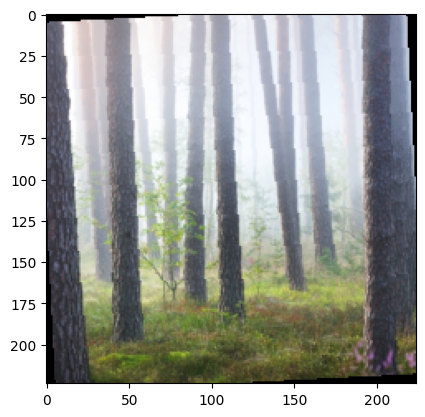

In [28]:
images,labels = next(iter(dataloaderView))
imshow(images[0].permute(1, 2, 0))

In [29]:
torch.save(model.state_dict(), 'model.pth')

In [30]:
# Assuming CustomModel is the class of your model
model = CustomModel()
model.load_state_dict(torch.load('model.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

CustomModel(
  (base_model): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, ep

In [33]:
from torchvision import transforms
from PIL import Image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Load an image
image_path = '/content/drive/MyDrive/Workshop/2. Image classification/data/fire/00000000.jpg'
input_image = Image.open(image_path)

# Preprocess the image
input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Make a prediction
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x62720 and 1280x128)

# **6. Visualiser une image préparée pour le modèle de base**

In [ ]:
#ancien

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

dataset = datasets.ImageFolder(training_path,preprocess)

# generate indices: instead of the actual data we pass in integers instead
#train_indices, valid_indices, _, _ = train_test_split(
    #range(len(dataset)),
    #dataset.targets,
    #stratify=dataset.targets,
    #test_size=validation_split,
    #random_state=seed
#)

train_indices, valid_indices, _, _ = train_test_split(
    np.arange(dataset.targets),
    dataset.targets,
    stratify=dataset.targets,
    test_size=validation_split,
    random_state=seed
)

# generate subset based on indices
train_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, valid_indices)

# create batches
dataloader={}
dataloader['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader['validation']  = DataLoader(validation_dataset, batch_size=batch_size)

In [ ]:
dataset = datasets.ImageFolder(training_path,preprocess)
generator1 = torch.Generator().manual_seed(seed)
dataloader={}
dataset= torch.utils.data.random_split(dataset, [0.8,0.2],generator=generator1)
dataset={'train':dataset[0],'validation':dataset[1]}
dataloader = {'train':DataLoader(dataset=dataset['train'], shuffle=True, batch_size=batch_size, drop_last=True),
                'validation':DataLoader(dataset=dataset['validation'], shuffle=False, batch_size=batch_size)
}
print(len(dataloader['train']),len(dataloader['validation']))




In [ ]:
images,labels = next(iter(dataloader['train']))
print(images[0])
imshow(images[0].permute(1, 2, 0))
#imshow(images[0])
print(labels[0])

# **7. Construction du modèle**

In [ ]:
#ancien

class Model(nn.Module):
  def __init__(self):
      super().__init__()
      self.base_model = base_model
      for param in self.base_model.parameters():
        param.requires_grad = False
      self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3,inplace=True),
            nn.Linear(1024, 3),
            nn.Softmax()
            )

  def forward(self,x):
    self.to(device)
    x = self.fc(self.base_model(x))
    return x

model=Model()


In [ ]:
del model
model=base_model
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
              nn.Linear(2048, 1024),
              nn.ReLU(inplace=True),
              nn.Dropout(p=0.3),
              nn.Linear(1024, 3),
              nn.Softmax(-1)
              )
model=model.to(device)
criterion = nn.CrossEntropyLoss()


# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
summary(model, (3, 224, 224))

In [ ]:
print(model)

# **8. Entraînement du modèle**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
              scheduler.step()

            epoch_loss = running_loss / len(dataset[phase])
            epoch_acc = running_corrects.double() / len(dataset[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=12)

# **Brouillon**

In [ ]:
#pour avoir la distribution des classes
print(dataset.class_to_idx)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print(idx_to_class)
def get_class_distribution(dataset):
    count_dict = {k:0 for k,v in dataset.class_to_idx.items()} # initialise dictionary

    for input, label in dataset:
        label = idx_to_class[label]
        count_dict[label] += 1

    return count_dict

print("Distribution of classes: ", get_class_distribution(dataset))

In [ ]:
class Model(nn.Module):
  def __init__(self, backbone):
      super().__init__()
      self.pretrained_model = None
      self.classifier_layers = []
      self.new_layers = []

      self.pretrained_model = base_model
      self.classifier_layers = [self.pretrained_model.fc]
      self.pretrained_model.fc = nn.Linear(
          in_features=2048, out_features=3, bias=True
      )
      self.pretrained_model.fc = nn.Sequential(
          torch.nn.AvgPool2d(kernel_size = 100, stride = 0, padding = 0, ceil_mode=False, count_include_pad=True),
          nn.Linear(1024, 512),


      out_features=3, bias=True
      )
      x = torch.nn.AvgPool2d(kernel_size = 100, stride = 0, padding = 0, ceil_mode=False, count_include_pad=True)(x)
      self.new_layers = [self.pretrained_model.fc]

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

  def freezing(self):
    for p in self.pretrained_model:
      p.requires_grad = False
    for l in self.new_layers:
      for p in l.parameters():
          p.requires_grad = True

  def get_optimizer_params(self):
    """This method is used only during model fine-tuning when we need to
    set a linearly or exponentially decaying learning rate (LR) for the
    layers in the model. We exponentially decay the learning rate as we
    move away from the last output layer.
    """
    options = []
    # For the resnet class of models, we decay the LR exponentially and reduce
    # it to a third of the previous value at each step.
    layers = ["conv1", "bn1", "layer1", "layer2", "layer3", "layer4", "fc"]
    lr = 0.0001
    for layer_name in reversed(layers):
        options.append(
            {
                "params": getattr(self.pretrained_model, layer_name).parameters(),
                "lr": lr,
            }
        )
        lr = lr / 3.0
    # end for
    return options

In [ ]:
optimizer = torch.optim.Adam(fc.get_optimizer_params(), lr=1e-8)

In [ ]:
class Model(nn.Module):
  def __init__(self):
    self.conv1 = base_model

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
dataset = datasets.ImageFolder(training_path,preprocess)
dataloaders = {
    'train':
    torch.utils.data.DataLoader(dataset['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

In [ ]:
next(iter(dataloader))

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')